# FYS-2021: Exercise set 3: Logistic Regression and Evaluation Metrics

## Task 1)


The sigmoid function for multiple features and multiple samples

In [2]:
from matplotlib.pyplot import xlabel
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import axes3d

# def sigmoid(w, X) :
def sigmoid(z) :
    # z = X  @ w.transpose()
    return 1/(1+np.exp(-z))


### 1a) 
Five bivariate instances for each of the two normal distributions. Plotting the instances in the cartesian plane (2d)

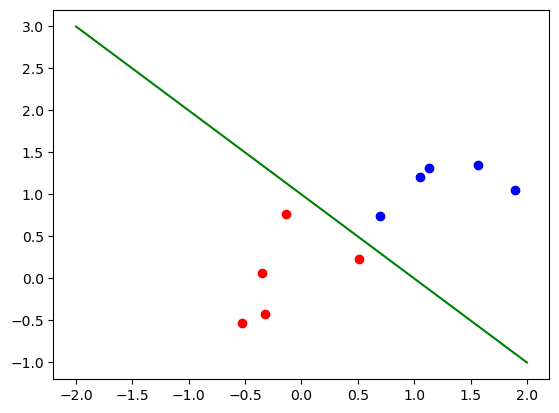

In [3]:
N_1 = multivariate_normal([0,0], cov=0.2)
N_2 = multivariate_normal([1,1], cov=0.2)

X_1 = N_1.rvs(5)
X_2 = N_2.rvs(5)

plt.scatter(X_1[:,0], X_1[:,1], color="red")
plt.scatter(X_2[:,0], X_2[:,1], color="blue")
x =np.linspace(-2,2, 50)
y = 1 - x    # Optimum regression line
plt.plot(x,y, color="green")


### 1b)
Transform the cartesian plane into a 3-d surface where the output of the sigmoid function is depicted on the z-axis

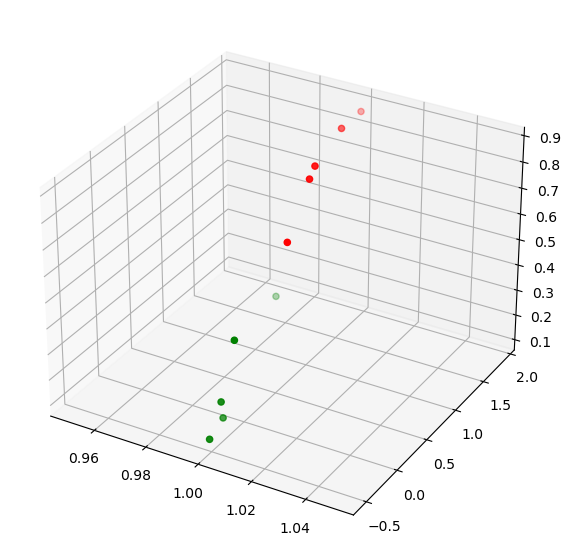

In [4]:
bias = np.ones((5,1))
X_1 = np.hstack((bias, X_1))
X_2 = np.hstack((bias, X_2))

# Suggested parameters for decision boundary. Here w[0] is the constant w_0
w = np.array([-1, 1, 1])

z_1 = sigmoid(X_1 @ w.T)
z_2 = sigmoid(X_2 @ w.T)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(X_1[:,0], X_1[:,1], z_1, color = "green")
ax.scatter(X_2[:,0], X_2[:,1], z_2, color = "red")

plt.show()


### 2a)
Implement vectorized version of logistic gradient descent

In [48]:
def gradient_descent(X: np.ndarray, y: np.ndarray) :

    # X will need the bias column as the first column
    N, d = X.shape  # N samples in d-1 features
    # w = np.random.randn(d,1)   # The + 1 is due to the bias...
    rng = np.random.default_rng()
    w = rng.standard_normal((d,1))   
    numIter = 0  # Inital number of iterations
    eta = 0.5    # Learning rate
    prev_error = 0
    total_error = 1
    tolerance = 0.0000001
    training_errors = []
    while abs(total_error - prev_error) > tolerance :
        prev_error = total_error
        z = X @ w
        h = sigmoid(z).reshape(z.size,1)
        
        grad = (X.T @ (h - y))/N   # Gradients. Need to transpose X so it will fit the matrix multiplication.
        w = w - eta*grad
        total_error = (np.sqrt((h - y).T @ (h - y)/N))
        numIter += 1
        training_errors.append(total_error.item())
        # print (total_error)

    return w, numIter, training_errors


### 2b)
Test the code with the tictac_end.csv 

Number of epochs until convergence:  8719
Accuracy on the training set: 0.9820627802690582
Accuracy on the test set: 0.9860627177700348
Confusion Matrix:
[[ 95   4]
 [  0 188]]


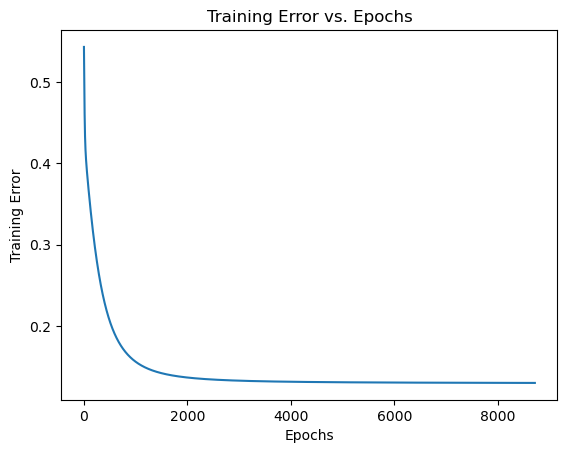

In [52]:
import pandas as pd

def predict(w, X):
    probabilities = sigmoid(np.dot(X, w))
    return (probabilities >= 0.5).astype(int)

data = pd.read_csv('data/tictac-end.csv', skiprows=7, delimiter=' ')
data = data.sample(frac=1.0, replace=False)
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:,0].to_numpy()

N, d = X.shape
endTrain = int(N*0.7)
X_train = X[:endTrain,:]
X_test = X[endTrain+1:,:]

y = np.reshape(y,(N,1))
y_train = y[:endTrain,:]
y_test = y[endTrain+1:,:]

bias = np.ones((endTrain,1))
X_train = np.concatenate((bias, X_train), axis=1)  # Added the extra column with ones

w, epochs, errors = gradient_descent(X_train, y_train)
print("Number of epochs until convergence: ", epochs)


# Make predictions on the test set
bias = np.ones((X_test.shape[0],1))
X_test = np.concatenate((bias,X_test), axis=1)


# Calculate accuracy on the training set
y_pred = predict(w, X_train)
print("Accuracy on the training set:", np.mean(y_pred == y_train))

# Calculate accuracy on the test set
y_pred = predict(w, X_test)
acc = np.mean(y_pred == y_test)
print("Accuracy on the test set:", acc)

# True Positives (TP): Label is 1, and prediction is 1
TP = np.sum(( y_test == 1) & (y_pred == 1))

# True Negatives (TN): Label is 0, and prediction is 0
TN = np.sum(( y_test == 0) & (y_pred == 0))

# False Positives (FP): Label is 0, but prediction is 1
FP = np.sum(( y_test == 0) & (y_pred == 1))

# False Negatives (FN): Label is 1, but prediction is 0
FN = np.sum(( y_test == 1) & (y_pred == 0))

# Creating the confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

print("Confusion Matrix:")
print(confusion_matrix)

plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs. Epochs')
plt.show()

### 4a)
Find the true positive and false positive rates. This might be a purely theoretical task, with the exception of the plotting perhaps...

### 5a)

AUC:  0.7859700000000015
Cutoff:  0.717


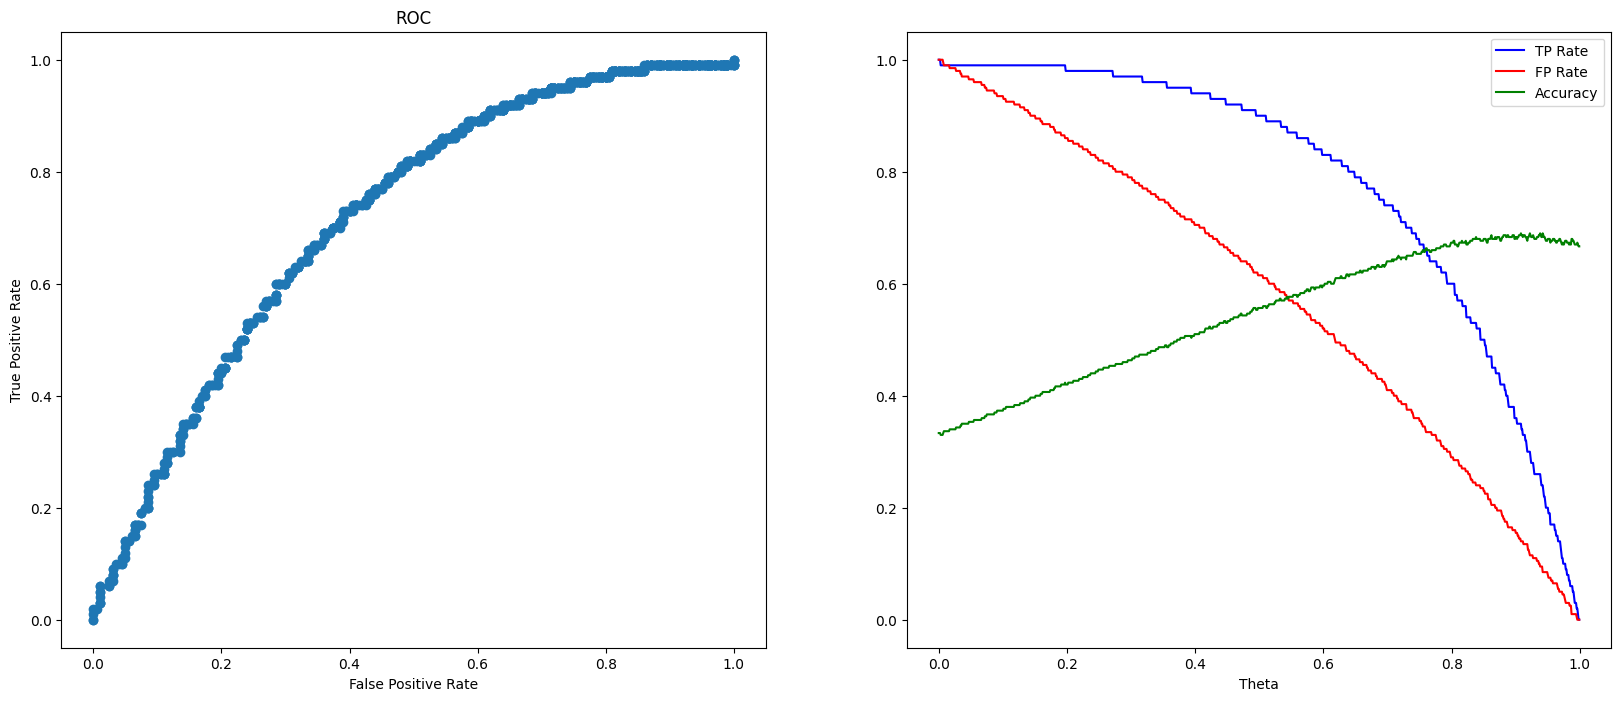

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

current_data = 3

dataframes = []
for i in range(3):
    dataframes.append(pd.read_csv("data/soft-classifications-" + str(i+1) + ".csv", delimiter=" ", comment="#", header=None))

df = dataframes[current_data-1]
ground_truth = df[0]
prob = df[1]

# Pick out the real negatives and positives
negatives_probs = prob[ground_truth==0]  
positives_probs = prob[ground_truth==1]

def tp_fp_rates(theta):
    
    TP = len(positives_probs[positives_probs > theta])
    TN = len(negatives_probs[negatives_probs <= theta])
    
    FN = len(positives_probs[positives_probs <= theta])
    FP = len(negatives_probs[negatives_probs > theta])
    
    accuracy = (TP+TN)/len(prob)
    return TP/(TP + FN), FP/(FP + TN), accuracy

thetas = np.arange(0,1,0.001)

tp_rate = []
fp_rate = []
accuracy = []
acc = []
AUC = 0
MaxJ = 0 # Youldon's J statistic for finding the optimum ROC cutoff
cutoff_theta = 0
for theta in thetas:
    TPR, FPR, acc = tp_fp_rates(theta)
    tp_rate.append(TPR)
    fp_rate.append(FPR)
    accuracy.append(acc)
    J= TPR - FPR
    if (J > MaxJ):
        MaxJ = J
        cutoff_theta = theta
    
    AUC += TPR
    
AUC = AUC/len(thetas)
print("AUC: ", AUC)
print("Cutoff: ", cutoff_theta)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(8)

ax1.scatter(fp_rate,tp_rate)
ax1.set_title("ROC")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.plot(thetas,tp_rate, color='b', label='TP Rate')
ax2.plot(thetas,fp_rate, color='r', label='FP Rate')
ax2.plot(thetas, accuracy, color='g', label='Accuracy')
ax2.set_xlabel("Theta")
ax2.legend()